In [1]:
import numpy as np
import os
from numpy.random import default_rng
from pprint import pprint

# from src.localization_utils import *
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
import matplotlib.ticker as mticker
from matplotlib.ticker import FormatStrFormatter
from sklearn.metrics import mean_squared_error
from brokenaxes import brokenaxes

mycolor = {                                                         
    'neutral0': '#1b4e6b', 
    'neutral1': '#38312d', 
    'neutral2': '#948b86', 
    'neutral3': '#d8ccc5', 
    'neutral4': '#C6D5CC', 
    'color1': '#ff7d82', 
    'color2': '#5c63a2', 
    'color3': '#b3619c', 
    'color4': '#f4ab33', 
}

fontsize = 15
title_fontsize = 15
plt.rcParams.update({'font.size': fontsize})

figsize = (10, 6)
figsize2 = (8, 4)

data_dir = "./data/"

mpl.rcParams['font.family'] = ['Noto Mono', 'serif'] # Noto Mono

In [2]:
# Useful functions

def set_font_size(ax, fontsize):
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(fontsize)

def plot_err_boxplots(err_list, ticks, whiskers, **kwargs):
    assert(ticks.size == len(err_list))
    if "figsize" in kwargs:
        fig, ax = plt.subplots(figsize=kwargs["figsize"])
    else:
        fig, ax = plt.subplots(figsize=(6.5, 4))
    
    if "widths" in kwargs:
        widths = kwargs["widths"]
    else:
        widths = 0.4
       
    bp = ax.boxplot(err_list, 
                    positions=ticks,
                    sym="", 
                    widths=widths,
                    showmeans=True,
                    whis=whiskers)
    def_linewidth = 2
    facecolor = mycolor["neutral1"]
    plt.setp(bp['fliers'], marker='o', markeredgecolor=mycolor["neutral1"], markerfacecolor="none",
             markersize=6, alpha=0.2)
    plt.setp(bp['boxes'], color=facecolor, linewidth=def_linewidth)
    plt.setp(bp['whiskers'], color=facecolor, linewidth=def_linewidth)
    plt.setp(bp['caps'], color=facecolor, linewidth=def_linewidth)
    plt.setp(bp['medians'], color=mycolor["color2"], linewidth=3)
    plt.setp(bp["means"], marker='D', markeredgecolor='black', markerfacecolor=mycolor["color1"],
             markersize=8)

    if "xlim" in kwargs:
        ax.set_xlim(kwargs["xlim"])
    if "ylim" in kwargs:
        ax.set_ylim(kwargs["ylim"])
    ax.grid(linestyle="-", linewidth=1, color=mycolor["neutral4"], alpha=0.3)
    set_font_size(ax, 18)
    return fig, ax

def compute_3d_loc_error(df, which_loc="tdoa"):
    gt = np.array([df["x_gt"], df["y_gt"], df["z_gt"]]).T
    loc = np.array([df["x_" + which_loc], df["y_" + which_loc], df["z_" + which_loc]]).T
    assert(gt.shape == loc.shape)
    
    errs = np.sqrt(np.sum((loc - gt) ** 2, axis=1))
    return errs

def parse_tag_anchors_locations(filepath, include_mlt=True):
    df = pd.read_csv(filepath, header=None)
    
    if include_mlt:
        nr_anchors = int((df.shape[1] - 25) / 3)
        columns = ["x_gt", "y_gt", "z_gt", 
                   "x_twr_mlt", "y_twr_mlt", "z_twr_mlt",
                   "x_tdoa_mlt", "y_tdoa_mlt", "z_tdoa_mlt",
                   "x_twr_ekf", "y_twr_ekf", "z_twr_ekf",
                   "x_tdoa_ekf", "y_tdoa_ekf", "z_tdoa_ekf"]
    else:
        nr_anchors = int((df.shape[1] - 15) / 3)
        columns = ["x_gt", "y_gt", "z_gt", 
                   "x_twr", "y_twr", "z_twr",
                   "x_tdoa", "y_tdoa", "z_tdoa"]
    
    for a in range(nr_anchors):
        columns.append("a{}_x".format(a))
        columns.append("a{}_y".format(a))
        columns.append("a{}_z".format(a))
        
    if include_mlt:
        columns.append("ts_twr_mlt")
        columns.append("ts_tdoa_mlt")
        columns.append("ts_twr_ekf")
        columns.append("ts_tdoa_ekf")
        columns.append("ts_anchors")
        columns.append("slot_nr_twr_mlt")
        columns.append("slot_nr_tdoa_mlt")
        columns.append("slot_nr_twr_ekf")
        columns.append("slot_nr_tdoa_ekf")
        columns.append("slot_nr_anchors")
    else:
        columns.append("ts_twr")
        columns.append("ts_tdoa")
        columns.append("ts_anchors")
        columns.append("slot_nr_twr")
        columns.append("slot_nr_tdoa")
        columns.append("slot_nr_anchors")
    
    df.columns = columns
    
    if include_mlt:
        # Change type of slot numbers to int
        df = df.astype({"slot_nr_twr_mlt": int, "slot_nr_tdoa_mlt": int,"slot_nr_twr_ekf": int, 
                        "slot_nr_tdoa_ekf": int, "slot_nr_anchors": int})
    else:
        df = df.astype({"slot_nr_twr": int, "slot_nr_tdoa": int, "slot_nr_anchors": int})
    
    return df

def plot_series_boxplots(data, whiskers, **kwargs):
    if "figsize" in kwargs:
        figsize = kwargs["figsize"]
    else:
        figsize = (16, 4)
        
    if "ax" in kwargs and "fig" in kwargs:
        fig = kwargs["fig"]
        ax = kwargs["ax"]
    else:
        fig, ax = plt.subplots(figsize=figsize)
    
    nr_boxes_in_cluster = len(data)
    nr_clusters = len(data[0])
    
    if "width" in kwargs:
        width = kwargs["width"]
    else:
        width = 0.2
    
    if "spacing" in kwargs:
        spacing = kwargs["spacing"]
    else:
        spacing = 1.9
    
    if "offset" in kwargs:
        offsets = np.linspace(-kwargs["offset"], kwargs["offset"], nr_boxes_in_cluster)
    else:
        offsets = np.linspace(-0.8, 0.8, nr_boxes_in_cluster)
    
    for i, data_series in enumerate(data):
        positions = np.linspace(0, nr_clusters * spacing, nr_clusters)
        positions += offsets[i]
        
        if "full_colors" in kwargs:
            color = kwargs["full_colors"][i]
            acc_color="black"
            
            if "do_means" in kwargs:
                bp = ax.boxplot(data_series, positions=positions, widths=width, sym="", 
                                patch_artist=True, showmeans=True, whis=whiskers)
                plt.setp(bp['means'], color="black", marker="d", 
                         mec="black", markerfacecolor="black", markersize=10)
            else:
                bp = ax.boxplot(data_series, positions=positions, sym="", widths=width, patch_artist=True,
                               whis=whiskers)
            plt.setp(bp['boxes'], color=acc_color, facecolor=color, linewidth=2)
            plt.setp(bp['whiskers'], color=acc_color, linewidth=2)
            plt.setp(bp['caps'], color=acc_color, linewidth=2)
            plt.setp(bp['medians'], color=acc_color, linewidth=2)
        else:
            bp = ax.boxplot(data_series, positions=positions, sym="", widths=width)
            
    if "xticklabels" in kwargs:
        assert(len(kwargs["xticklabels"]) == nr_clusters)
        xticks = np.linspace(0, nr_clusters * spacing, nr_clusters)
        ax.xaxis.set_major_locator(mticker.FixedLocator(xticks))
        ax.set_xticklabels(kwargs["xticklabels"])

    return fig, ax

def get_localization_err(filepath, which_loc, which_err="3d", start_idx=1000, include_mlt=True):
    df = parse_tag_anchors_locations(os.path.join(filepath, "localization.csv"), include_mlt)
    df = df[start_idx:]
    if which_err == "3d":
        errs = compute_3d_loc_error(df, which_loc=which_loc)
    elif which_err == "2d":
        errs = compute_2d_loc_error(df, which_loc=which_loc)
    return errs

# V-A: Order of response

## TWR

In [3]:
nr_responders = 9
nr_anchors = 11

root_dir = os.path.join(data_dir, "order_response")
twr_df = pd.read_csv(os.path.join(root_dir, "twr.csv"))
twr_df.head(3)

,slot_nr,resp0_id,resp0_dist,resp1_id,resp1_dist,resp2_id,resp2_dist,resp3_id,resp3_dist,resp4_id,...,resp4_true_dist,resp4_err,resp5_true_dist,resp5_err,resp6_true_dist,resp6_err,resp7_true_dist,resp7_err,resp8_true_dist,resp8_err
0,692751,9,214,0,459,1,372,2,342,3,...,418.935486,0.064514,213.143052,-3.143052,257.839396,1.160604,246.230402,-1.230402,209.932386,-2.932386
1,692752,0,455,1,369,2,344,3,414,4,...,213.143052,-1.143052,257.839396,12.160604,246.230402,1.769598,209.932386,-1.932386,223.861733,-16.861733
2,692753,1,370,2,338,3,413,4,214,5,...,257.839396,3.160604,246.230402,-2.230402,209.932386,4.067614,223.861733,-13.861733,213.037951,3.962049


Order 0: m_err = -1.45 cm, std_err = 4.83 cm, P95 - P5 = 18.05 cm
Order 1: m_err = -1.37 cm, std_err = 4.88 cm, P95 - P5 = 17.05 cm
Order 2: m_err = -1.37 cm, std_err = 5.13 cm, P95 - P5 = 18.02 cm
Order 3: m_err = -1.36 cm, std_err = 5.39 cm, P95 - P5 = 18.05 cm
Order 4: m_err = -1.32 cm, std_err = 5.57 cm, P95 - P5 = 18.10 cm
Order 5: m_err = -1.27 cm, std_err = 5.86 cm, P95 - P5 = 19.72 cm
Order 6: m_err = -1.27 cm, std_err = 6.19 cm, P95 - P5 = 20.10 cm
Order 7: m_err = -1.22 cm, std_err = 6.56 cm, P95 - P5 = 22.02 cm
Order 8: m_err = -1.17 cm, std_err = 6.87 cm, P95 - P5 = 22.14 cm


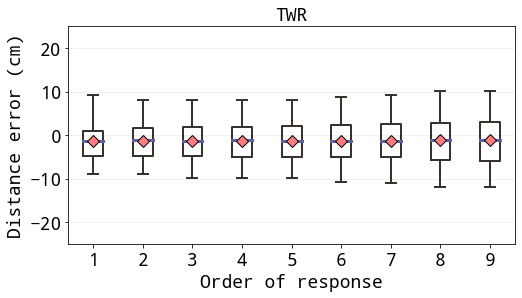

In [4]:
list_errors = []
for idx_order in range(nr_responders):
    err = list(twr_df["resp{}_err".format(idx_order)])
    
    list_errors.append(err)
    
    # Compute statistics
    p5, p95 = np.percentile(err, [5, 95])
    spr = p95 - p5
    print("Order {}: m_err = {:.2f} cm, std_err = {:.2f} cm, P95 - P5 = {:.2f} cm".format(
        idx_order, np.mean(err), np.std(err), spr))

ticks = np.arange(1, nr_responders + 1, 1)
fig1, ax1 = plot_err_boxplots(list_errors, ticks, figsize=figsize2, whiskers=[5, 95])
ax1.set_title("TWR")
ax1.set_xlabel("Order of response")
ax1.set_ylabel("Distance error (cm)")
ax1.set_ylim((-25, 25))
ax1.grid(axis="x")
plt.show()

## TDOA

In [5]:
nr_responders = 9
nr_anchors = 10

root_dir = os.path.join(data_dir, "order_response")
tdoa_df = pd.read_csv(os.path.join(root_dir, "tdoa.csv"))
tdoa_df.head(3)

,slot_nr,initiator,resp0_id,resp0_tdoa,resp1_id,resp1_tdoa,resp2_id,resp2_tdoa,resp3_id,resp3_tdoa,...,resp4_true_tdoa,resp4_err,resp5_true_tdoa,resp5_err,resp6_true_tdoa,resp6_err,resp7_true_tdoa,resp7_err,resp8_true_tdoa,resp8_err
0,200308,8,1,457.78670,2,400.8520,3,771.2367,4,321.8761,...,340.374515,12.954085,407.129925,4.721575,395.193594,-10.184294,384.670204,-9.298204,827.848143,30.877257
1,200309,9,4,212.51320,5,260.8485,6,424.9352,7,233.8905,...,406.317768,-17.957968,535.241606,11.418894,561.416355,5.900745,642.316210,12.589590,640.222690,10.639410
2,200310,0,4,51.15514,5,181.9131,6,351.3622,7,139.9997,...,361.993976,2.978224,47.739875,8.393025,382.760757,-2.812357,530.482629,8.009671,421.112245,7.890355


Order 0: m_err = 0.69 cm, std_err = 9.01 cm, P95 - P5 = 29.34 cm
Order 1: m_err = 0.86 cm, std_err = 9.35 cm, P95 - P5 = 30.34 cm
Order 2: m_err = 0.93 cm, std_err = 9.74 cm, P95 - P5 = 31.77 cm
Order 3: m_err = 0.96 cm, std_err = 10.18 cm, P95 - P5 = 33.34 cm
Order 4: m_err = 1.08 cm, std_err = 10.72 cm, P95 - P5 = 35.03 cm
Order 5: m_err = 1.15 cm, std_err = 11.36 cm, P95 - P5 = 37.19 cm
Order 6: m_err = 1.22 cm, std_err = 12.00 cm, P95 - P5 = 39.42 cm
Order 7: m_err = 1.34 cm, std_err = 12.70 cm, P95 - P5 = 41.61 cm
Order 8: m_err = 1.33 cm, std_err = 13.46 cm, P95 - P5 = 44.03 cm


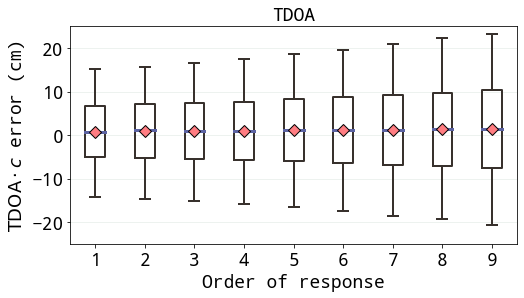

In [6]:
list_errors = []
for i_order in range(nr_responders):
    err = np.array(tdoa_df["resp{}_err".format(i_order)])
    
    # For some reason, there were 4 outliers with errors of over 4 m. We decided to eliminate
    # the outliers, as they don't reflect the overall statistics.
    err = err[np.abs(err) < 400] 
    list_errors.append(list(err))
    
    # Compute stats
    p5, p95 = np.percentile(err, [5, 95])
    spr = p95 - p5
    print("Order {}: m_err = {:.2f} cm, std_err = {:.2f} cm, P95 - P5 = {:.2f} cm".format(
        i_order, np.mean(err), np.std(err), spr))

ticks = np.arange(1, nr_responders + 1, 1)
fig1, ax1 = plot_err_boxplots(list_errors, ticks, figsize=figsize2, whiskers=[5, 95])
ax1.set_title("TDOA")
ax1.set_xlabel("Order of response")
ax1.set_ylabel("$\mathrm{TDOA} \cdot c $ error (cm)")
ax1.set_ylim((-25, 25))
ax1.grid(axis="x")
plt.show()

# V-B: Number of responses

## TWR

Nr resp:  1 (6505, 55)
	3D: Mean = 7.25 cm, med = 7.27 cm, std = 2.32 cm, IQR = 3.19 cm, P95 = 11.02 cm
Nr resp:  2 (6607, 55)
	3D: Mean = 7.23 cm, med = 7.26 cm, std = 2.27 cm, IQR = 3.23 cm, P95 = 11.16 cm
Nr resp:  3 (6709, 55)
	3D: Mean = 7.29 cm, med = 7.30 cm, std = 2.41 cm, IQR = 3.39 cm, P95 = 11.11 cm
Nr resp:  4 (6697, 55)
	3D: Mean = 7.28 cm, med = 7.19 cm, std = 2.31 cm, IQR = 3.28 cm, P95 = 11.31 cm
Nr resp:  5 (6682, 55)
	3D: Mean = 7.28 cm, med = 7.20 cm, std = 2.34 cm, IQR = 3.20 cm, P95 = 11.32 cm
Nr resp:  6 (6671, 55)
	3D: Mean = 7.35 cm, med = 7.29 cm, std = 2.43 cm, IQR = 3.19 cm, P95 = 11.49 cm
Nr resp:  7 (6663, 55)
	3D: Mean = 7.39 cm, med = 7.23 cm, std = 2.44 cm, IQR = 3.33 cm, P95 = 11.71 cm
Nr resp:  8 (6644, 55)
	3D: Mean = 7.48 cm, med = 7.31 cm, std = 2.48 cm, IQR = 3.36 cm, P95 = 11.81 cm
Nr resp:  9 (6711, 55)
	3D: Mean = 7.61 cm, med = 7.41 cm, std = 2.65 cm, IQR = 3.46 cm, P95 = 12.12 cm


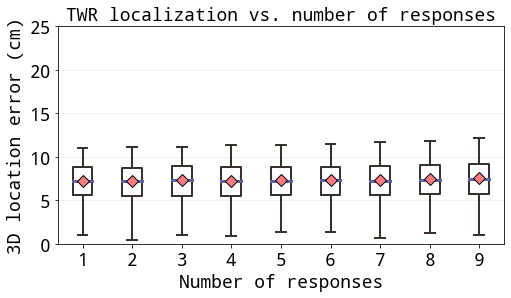

In [7]:
max_nr_responses = 9
nr_devices = 10
root_dir = os.path.join(data_dir, "nr_responses")

# Eliminate the first measurements to account for the EKF convergence in computing the 
# anchors' locations
start_idx = 2000

errs_list_3d = []
errs_list_2d = []
for nr_resp in range(1, max_nr_responses + 1):
    rec_dir = os.path.join(root_dir, "loc_twr_{}_{}_CI-CR".format(nr_devices, nr_resp))
    loc_filepath = os.path.join(rec_dir, "localization.csv")
    df = parse_tag_anchors_locations(loc_filepath)
    df = df[start_idx:]
    
    print("Nr resp: ", nr_resp, df.shape)
    errs_3d = compute_3d_loc_error(df, which_loc="twr_mlt")
    errs_list_3d.append(errs_3d)
    
    q3, q1 = np.percentile(errs_3d, [75, 25])
    iqr_3d = q3 - q1
    decision_3d = (q3 + 1.5 * iqr_3d) - (q1 - 1.5 * iqr_3d)
    
    print("\t3D: Mean = {:.2f} cm, med = {:.2f} cm, std = {:.2f} cm, IQR = {:.2f} cm, P95 = {:.2f} cm".format(
        np.mean(errs_3d), np.median(errs_3d), np.std(errs_3d), iqr_3d, np.percentile(errs_3d, 95)))
    
ticks = np.arange(1, max_nr_responses + 1, 1)
    
fig1, ax1 = plot_err_boxplots(errs_list_3d, ticks, ylim=(-0.25, 15), figsize=figsize2, whiskers=[0, 95])
ax1.set_ylabel("3D location error (cm)")
ax1.set_title("TWR localization vs. number of responses")
ax1.set_xlabel("Number of responses")
ax1.grid(axis="x")
ax1.set_ylim((0, 25))
plt.show()

## TDOA

Nr resp:  1 (6565, 55)
	3D: Mean = 9.15 cm, med = 8.64 cm, std = 6.50 cm, IQR = 4.85 cm, P95 = 15.32 cm
Nr resp:  2 (6582, 55)
	3D: Mean = 9.49 cm, med = 8.88 cm, std = 5.14 cm, IQR = 5.23 cm, P95 = 16.90 cm
Nr resp:  3 (6475, 55)
	3D: Mean = 10.31 cm, med = 9.27 cm, std = 6.37 cm, IQR = 6.08 cm, P95 = 19.87 cm
Nr resp:  4 (6475, 55)
	3D: Mean = 9.95 cm, med = 9.10 cm, std = 5.11 cm, IQR = 5.68 cm, P95 = 19.00 cm
Nr resp:  5 (6345, 55)
	3D: Mean = 10.36 cm, med = 9.39 cm, std = 6.25 cm, IQR = 5.99 cm, P95 = 19.52 cm
Nr resp:  6 (6221, 55)
	3D: Mean = 10.51 cm, med = 9.64 cm, std = 5.43 cm, IQR = 6.16 cm, P95 = 19.68 cm
Nr resp:  7 (6374, 55)
	3D: Mean = 10.50 cm, med = 9.68 cm, std = 5.65 cm, IQR = 6.24 cm, P95 = 19.78 cm
Nr resp:  8 (6424, 55)
	3D: Mean = 10.86 cm, med = 10.07 cm, std = 5.14 cm, IQR = 6.37 cm, P95 = 20.74 cm
Nr resp:  9 (6428, 55)
	3D: Mean = 11.05 cm, med = 10.16 cm, std = 5.37 cm, IQR = 6.49 cm, P95 = 20.51 cm


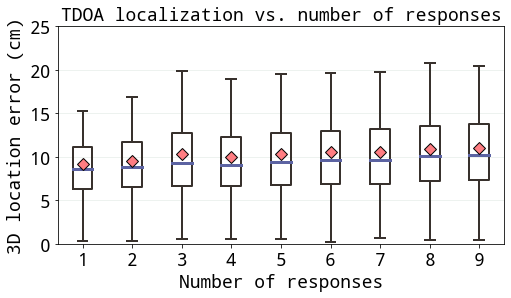

In [8]:
max_nr_responses = 9
nr_devices = 10
root_dir = os.path.join(data_dir, "nr_responses")

# Eliminate the first measurements to account for the EKF convergence in computing the 
# anchors' locations
start_idx = 2000 

errs_list_3d = []
for nr_resp in range(1, max_nr_responses + 1):
    rec_dir = os.path.join(root_dir, "loc_tdoa_{}_{}_CI-CR".format(nr_devices, nr_resp))
    loc_filepath = os.path.join(rec_dir, "localization.csv")
    df = parse_tag_anchors_locations(loc_filepath)
    df = df[start_idx:]
    
    print("Nr resp: ", nr_resp, df.shape)
    errs_3d = compute_3d_loc_error(df, which_loc="tdoa_mlt")
    errs_list_3d.append(errs_3d)
    
    q3, q1 = np.percentile(errs_3d, [75, 25])
    iqr_3d = q3 - q1
    decision_3d = (q3 + 1.5 * iqr_3d) - (q1 - 1.5 * iqr_3d)
    
    print("\t3D: Mean = {:.2f} cm, med = {:.2f} cm, std = {:.2f} cm, IQR = {:.2f} cm, P95 = {:.2f} cm".format(
        np.mean(errs_3d), np.median(errs_3d), np.std(errs_3d), iqr_3d, np.percentile(errs_3d, 95)))
    
ticks = np.arange(1, max_nr_responses + 1, 1)
    
fig1, ax1 = plot_err_boxplots(errs_list_3d, ticks, ylim=(-0.25, 35), figsize=figsize2, whiskers=[0, 95])
ax1.set_title("TDOA localization vs. number of responses")
ax1.set_ylabel("3D location error (cm)")
ax1.set_xlabel("Number of responses")
ax1.grid(axis="x")
ax1.set_ylim((0, 25))
    
plt.show()

# V-C: Number of responses for different tag speeds

## 1) Same transmission time

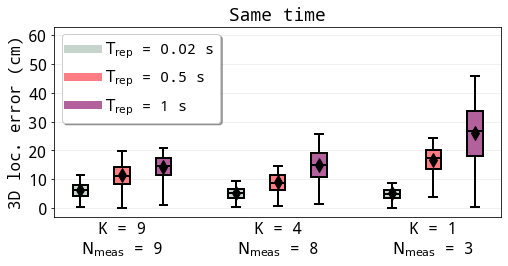

In [9]:
plt.rcParams.update({'font.size': 16})
dict_files_same_time = {
    0.02: {
        "K9_M9": "loc_tdoa_20ms_10_9_CI-CR_baseline",
        "K4_M8": "loc_tdoa_20ms_10_4_CI-CR_same_time_power",
        "K1_M3": "loc_tdoa_20ms_10_1_CI-CR_same_time",
    },
    0.5: {
        "K9_M9": "loc_tdoa_500ms_10_9_CI-CR_baseline",
        "K4_M8": "loc_tdoa_500ms_10_4_CI-CR_same_time_power",
        "K1_M3": "loc_tdoa_500ms_10_1_CI-CR_same_time",
    },
    1: {
        "K9_M9": "loc_tdoa_1s_10_9_CI-CR_baseline",
        "K4_M8": "loc_tdoa_1s_10_4_CI-CR_same_time_power",
        "K1_M3": "loc_tdoa_1s_10_1_CI-CR_same_time",
    },
}

root_dir = os.path.join(data_dir, "speed_variation")

list_errs = []
K_M_list = [(9, 9), (4, 8), (1, 3)]
Trep_list = [0.02, 0.5, 1]

for Trep in Trep_list:
    dict_fn = dict_files_same_time[Trep]
    list_errs_Trep = []
    for (K, M) in K_M_list:
        fn = dict_fn["K{}_M{}".format(K, M)]
        filepath = os.path.join(root_dir, fn)
        errs = get_localization_err(filepath, which_loc="tdoa", include_mlt=False)
        list_errs_Trep.append(list(errs))
    list_errs.append(list_errs_Trep)
    
color_list = [mycolor["neutral4"], mycolor["color1"], 
              mycolor["color3"]]

xtick_labels = []
for (K, M) in K_M_list:
    l = "K = {}\n".format(K)
    l += "$\mathrm{N}_\mathrm{meas}$ = " + str(M)
    xtick_labels.append(l)

fig, ax = plot_series_boxplots(list_errs, figsize=(8, 3.5), 
                                xticklabels=xtick_labels,
                                full_colors=color_list,
                                spacing=2,
                                width=0.3,
                                do_means=True,
                                whiskers=[0, 95])
ax.set_ylabel("3D loc. error (cm)")

# Add labels
labels = ["$\mathrm{T}_\mathrm{rep}$ = " + "{}".format(Trep) + " s" for Trep in Trep_list]
lw = 8
for l, c in zip(labels, color_list):
    ax.plot([], c=c, linewidth=lw, label=l)

# Legend inside the plot
ax.legend(#bbox_to_anchor=(0.36, 0.47, 1, 0.5), 
          loc='upper left', 
          fancybox=True, 
          shadow=True, 
          ncol=1,
          handletextpad=0.5, # make the padding between rows smaller
          prop={'size': fontsize}, # make font smaller so all elements fit
          markerscale=1, # make markers in the legend larger
          )

ax.set_ylim((-3, 63))
yticks = np.arange(0, 63, 10)
ax.yaxis.set_major_locator(mticker.FixedLocator(yticks))
ax.grid(axis="y", linestyle="-", linewidth=1, color=mycolor["neutral3"], alpha=0.3)
ax.set_title("Same time", fontsize=18)
ax.tick_params(axis='x', which='both',length=0)

plt.show()

## 2) Same number of messages

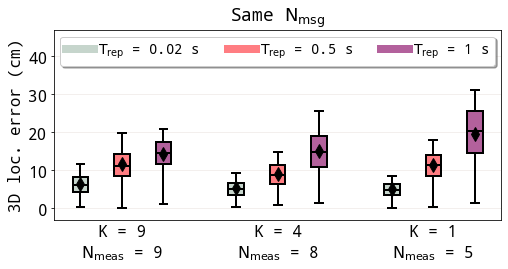

In [10]:
dict_files_same_time = {
    0.02: {
        "K9_M9": "loc_tdoa_20ms_10_9_CI-CR_baseline",
        "K4_M8": "loc_tdoa_20ms_10_4_CI-CR_same_time_power",
        "K1_M5": "loc_tdoa_20ms_10_1_CI-CR_same_power",
    },
    0.5: {
        "K9_M9": "loc_tdoa_500ms_10_9_CI-CR_baseline",
        "K4_M8": "loc_tdoa_500ms_10_4_CI-CR_same_time_power",
        "K1_M5": "loc_tdoa_500ms_10_1_CI-CR_same_power",
    },
    1: {
        "K9_M9": "loc_tdoa_1s_10_9_CI-CR_baseline",
        "K4_M8": "loc_tdoa_1s_10_4_CI-CR_same_time_power",
        "K1_M5": "loc_tdoa_1s_10_1_CI-CR_same_power",
    },
}

root_dir = os.path.join(data_dir, "speed_variation")

list_errs = []
K_M_list = [(9, 9), (4, 8), (1, 5)]
Trep_list = [0.02, 0.5, 1]

for Trep in Trep_list:
    dict_fn = dict_files_same_time[Trep]
    list_errs_Trep = []
    for (K, M) in K_M_list:
        fn = dict_fn["K{}_M{}".format(K, M)]
        filepath = os.path.join(root_dir, fn)
        errs = get_localization_err(filepath, which_loc="tdoa", include_mlt=False)
        list_errs_Trep.append(list(errs))
    list_errs.append(list_errs_Trep)
    
color_list = [mycolor["neutral4"], mycolor["color1"], 
              mycolor["color3"]]

xtick_labels = []
for (K, M) in K_M_list:
    l = "K = {}\n".format(K)
    l += "$\mathrm{N}_\mathrm{meas}$ = " + str(M)
    xtick_labels.append(l)

fig, ax = plot_series_boxplots(list_errs, figsize=(8, 3.5), 
                                xticklabels=xtick_labels,
                                full_colors=color_list,
                                spacing=2,
                                width=0.3,
                                do_means=True,
                                whiskers=[0, 95])
ax.set_ylabel("3D loc. error (cm)")

# Add labels
labels = ["$\mathrm{T}_\mathrm{rep}$ = " + "{}".format(Trep) + " s" for Trep in Trep_list]
lw = 8
for l, c in zip(labels, color_list):
    ax.plot([], c=c, linewidth=lw, label=l)
# Legend inside the plot
ax.legend(#bbox_to_anchor=(0.36, 0.47, 1, 0.5), 
          loc='upper center', 
          fancybox=True, 
          shadow=True, 
          ncol=3,
          handletextpad=0.3, # make the padding between rows smaller
          prop={'size': 14}, # make font smaller so all elements fit
          markerscale=1, # make markers in the legend larger
          )

ax.set_ylim((-3, 47))
yticks = np.arange(0, 43, 10)
ax.yaxis.set_major_locator(mticker.FixedLocator(yticks))

ax.grid(axis="y", linestyle="-", linewidth=1, color=mycolor["neutral3"], alpha=0.3)
ax.set_title("Same $\mathrm{N}_\mathrm{msg}$", fontsize=18)
ax.tick_params(axis='x', which='both',length=0)
plt.show()

# V-D: Number of anchors

## TWR

Nr devices:  5
	3D: Mean = 6.76 cm, std = 2.24 cm, std = 3.16 cm
Nr devices:  6
	3D: Mean = 6.99 cm, std = 2.21 cm, std = 3.02 cm
Nr devices:  7
	3D: Mean = 7.09 cm, std = 2.39 cm, std = 3.47 cm
Nr devices:  8
	3D: Mean = 7.03 cm, std = 3.41 cm, std = 3.07 cm
Nr devices:  9
	3D: Mean = 6.95 cm, std = 2.08 cm, std = 2.80 cm
Nr devices:  10
	3D: Mean = 7.24 cm, std = 2.32 cm, std = 3.37 cm


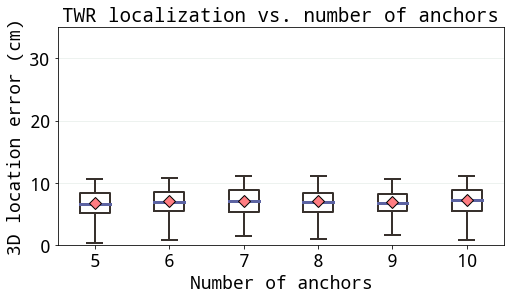

In [11]:
nr_responses = 4
min_nr_devices = 5
max_nr_devices = 10
root_dir = os.path.join(data_dir, "nr_anchors")
start_idx = 2000

errs_list_3d = []
errs_list_2d = []
for nr_devices in range(min_nr_devices, max_nr_devices + 1):
    rec_dir = os.path.join(root_dir, "loc_twr_{}_{}_CI-CR".format(nr_devices, nr_responses))
    loc_filepath = os.path.join(rec_dir, "localization.csv")
    df = parse_tag_anchors_locations(loc_filepath)
    df = df[start_idx:]
    
    print("Nr devices: ", nr_devices)
    errs_3d = compute_3d_loc_error(df, which_loc="twr_mlt")
    errs_list_3d.append(errs_3d)
    
    q3, q1 = np.percentile(errs_3d, [75, 25])
    iqr_3d = q3 - q1
    
    print("\t3D: Mean = {:.2f} cm, std = {:.2f} cm, std = {:.2f} cm".format(
        np.mean(errs_3d), np.std(errs_3d), iqr_3d))
    
ticks = np.arange(min_nr_devices, max_nr_devices + 1, 1)
    
fig1, ax1 = plot_err_boxplots(errs_list_3d, ticks, ylim=(-0.25, 15), figsize=figsize2, whiskers=[0, 95])
ax1.set_title("TWR localization vs. number of anchors")
ax1.set_ylabel("3D location error (cm)")
ax1.set_xlabel("Number of anchors")
ax1.grid(axis="x")
ax1.set_ylim((0, 35))
plt.show()

## TDOA

Nr devices:  5
	3D: Mean = 11.95 cm, std = 5.44 cm, iqr = 7.50 cm, p95 = 22.05 cm
Nr devices:  6
	3D: Mean = 16.42 cm, std = 18.54 cm, iqr = 9.92 cm, p95 = 33.19 cm
Nr devices:  7
	3D: Mean = 11.41 cm, std = 6.54 cm, iqr = 7.34 cm, p95 = 22.53 cm
Nr devices:  8
	3D: Mean = 11.32 cm, std = 6.84 cm, iqr = 7.31 cm, p95 = 23.84 cm
Nr devices:  9
	3D: Mean = 10.30 cm, std = 6.01 cm, iqr = 5.96 cm, p95 = 19.90 cm
Nr devices:  10
	3D: Mean = 10.30 cm, std = 6.64 cm, iqr = 6.14 cm, p95 = 20.00 cm


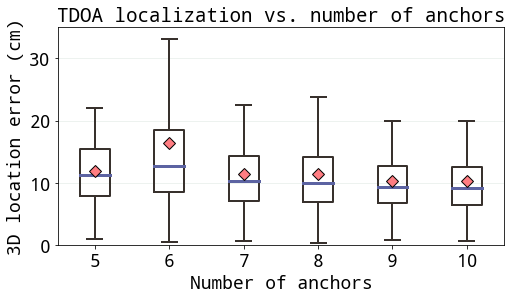

In [12]:
nr_responses = 4
min_nr_devices = 5
max_nr_devices = 10
root_dir = os.path.join(data_dir, "nr_anchors")
start_idx = 2000

errs_list_3d = []
errs_list_2d = []
for nr_devices in range(min_nr_devices, max_nr_devices + 1):
    rec_dir = os.path.join(root_dir, "loc_tdoa_{}_{}_CI-CR".format(nr_devices, nr_responses))
    loc_filepath = os.path.join(rec_dir, "localization.csv")
    df = parse_tag_anchors_locations(loc_filepath)
    df = df[start_idx:]
    
    print("Nr devices: ", nr_devices)
    errs_3d = compute_3d_loc_error(df, which_loc="tdoa_mlt")
    errs_list_3d.append(errs_3d)
    
    q3, q1 = np.percentile(errs_3d, [75, 25])
    iqr_3d = q3 - q1
    p95 = np.percentile(errs_3d, 95)
    
    print("\t3D: Mean = {:.2f} cm, std = {:.2f} cm, iqr = {:.2f} cm, p95 = {:.2f} cm".format(
        np.mean(errs_3d), np.std(errs_3d), iqr_3d, p95))
    
ticks = np.arange(min_nr_devices, max_nr_devices + 1, 1)
    
fig1, ax1 = plot_err_boxplots(errs_list_3d, ticks, ylim=(-0.25, 35), figsize=figsize2, whiskers=[0, 95])
ax1.set_title("TDOA localization vs. number of anchors")
ax1.set_ylabel("3D location error (cm)")
ax1.set_xlabel("Number of anchors")
ax1.grid(axis="x")
ax1.set_ylim((0, 35))
plt.show()

# VI-A: Fixed vs. Changing Initiator and/or Response Order

## Comparison FI-FR, FI-CR, CI-FR, CI-CR

In [13]:
root_dir = os.path.join(data_dir, "fixed_vs_changing/P1")

dict_exp = {
    "fi_fr": {
        "pretty_name": "Fixed initiator, fixed response order",
        "abbrev": "FI-FR",
        "color": mycolor["color1"],
        "recordings_filepaths": {
            "5_anchors": {"4_resp": os.path.join(root_dir, "loc_tdoa_A1_FI_FR_5_4"),},
            "7_anchors": {"6_resp": os.path.join(root_dir, "loc_tdoa_A1_FI_FR_7_6"),},
            "10_anchors": {"9_resp": os.path.join(root_dir, "loc_tdoa_A1_FI_FR_10_9"),},
        },
    },
    "fi_cr": {
        "pretty_name": "Fixed initiator, changing response order",
        "abbrev": "FI-CR",
        "color": mycolor["color2"],
        "recordings_filepaths": {
            "5_anchors": {"4_resp": os.path.join(root_dir, "loc_tdoa_A1_FI_CR_5_4"),},
            "7_anchors": {"6_resp": os.path.join(root_dir, "loc_tdoa_A1_FI_CR_7_6"),},
            "10_anchors": {"9_resp": os.path.join(root_dir, "loc_tdoa_A1_FI_CR_10_9"),},
        },
    },
    "ci_fr": {
        "pretty_name": "Changing initiator, fixed response order",
        "abbrev": "CI-FR",
        "color": mycolor["color3"],
        "recordings_filepaths": {
            "5_anchors": {"4_resp": os.path.join(root_dir, "loc_tdoa_CI_FR_5_4"),},
            "7_anchors": {"6_resp": os.path.join(root_dir, "loc_tdoa_CI_FR_7_6"),},
            "10_anchors": {"9_resp": os.path.join(root_dir, "loc_tdoa_CI_FR_10_9"),},
        },
    },
    "ci_cr": {
        "pretty_name": "Changing initiator, changing response order",
        "abbrev": "CI-CR",
        "color": mycolor["color4"],
        "recordings_filepaths": {
            "5_anchors": {"4_resp": os.path.join(root_dir, "loc_tdoa_CI_CR_5_4"),},
            "7_anchors": {"6_resp": os.path.join(root_dir, "loc_tdoa_CI_CR_7_6"),},
            "10_anchors": {"9_resp": os.path.join(root_dir, "loc_tdoa_CI_CR_10_9"),},
        },
    },
}

fi_fr, N = 5, K = 4, RMSE 3D = 20.43 cm
fi_fr, N = 7, K = 6, RMSE 3D = 21.92 cm
fi_fr, N = 10, K = 9, RMSE 3D = 14.26 cm
fi_cr, N = 5, K = 4, RMSE 3D = 18.74 cm
fi_cr, N = 7, K = 6, RMSE 3D = 17.73 cm
fi_cr, N = 10, K = 9, RMSE 3D = 14.72 cm
ci_fr, N = 5, K = 4, RMSE 3D = 15.76 cm
ci_fr, N = 7, K = 6, RMSE 3D = 13.35 cm
ci_fr, N = 10, K = 9, RMSE 3D = 11.69 cm
ci_cr, N = 5, K = 4, RMSE 3D = 24.47 cm
ci_cr, N = 7, K = 6, RMSE 3D = 13.26 cm
ci_cr, N = 10, K = 9, RMSE 3D = 11.97 cm


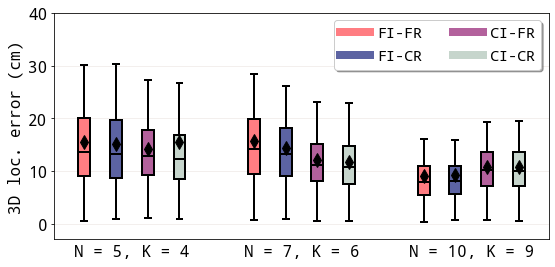

In [14]:
methods = list(dict_exp.keys())

list_errs = []
for m in methods:
    list_errs_methods = []
    for (N, K) in [(5, 4), (7, 6), (10, 9)]:
        filepath = dict_exp[m]["recordings_filepaths"]["{}_anchors".format(N)]["{}_resp".format(K)]
        
        errs = get_localization_err(filepath, which_loc="tdoa_mlt", which_err="3d")
        rmse_3d = np.sqrt(np.sum(errs ** 2) / errs.size)
        
        
        print("{}, N = {}, K = {}, RMSE 3D = {:.2f} cm".format(
            m, N, K, rmse_3d))
        
        list_errs_methods.append(list(errs))
    list_errs.append(list_errs_methods)

color_list = [mycolor["color1"], mycolor["color2"], 
              mycolor["color3"], mycolor["neutral4"]]
fig, ax = plot_series_boxplots(list_errs, figsize=(8, 4), 
                                xticklabels=["N = 5, K = 4", "N = 7, K = 6", "N = 10, K = 9"],
                                full_colors=color_list,
                                do_means=True,
                                whiskers=[0, 95])
ax.set_ylabel("3D loc. error (cm)")

# Add labels
labels = [dict_exp[m]["abbrev"] for m in methods]
lw = 8
for l, c in zip(labels, color_list):
    ax.plot([], c=c, linewidth=lw, label=l)
ax.legend(#bbox_to_anchor=(0.36, 0.47, 1, 0.5), 
          loc='upper right', 
          fancybox=True, 
          shadow=True, 
          ncol=2,
          handletextpad=0.5, # make the padding between rows smaller
          prop={'size': fontsize}, # make font smaller so all elements fit
          markerscale=1, # make markers in the legend larger
          )
ax.grid(axis="y", linestyle="-", linewidth=1, color=mycolor["neutral3"], alpha=0.3)
ax.tick_params(axis='x', which='both',length=0)
ax.set_ylim((-3, 40))
fig.tight_layout()
plt.show()

## Comparison FI-FR and CI-CR, aggregated errors (over all locations)

In [15]:
root_dir = os.path.join(data_dir, "fixed_vs_changing")

dict_exp = {
    "fi_fr": {
        "pretty_name": "Fixed initiator, fixed response order",
        "abbrev": "Classic TDOA (FI-FR)",
        "color": mycolor["color1"],
        "recordings_filepaths": {
            "5_anchors": {
                os.path.join(root_dir, "P1/loc_tdoa_A1_FI_FR_5_4"),
                os.path.join(root_dir, "P2/loc_tdoa_A1_FI_FR_5_4"),
                os.path.join(root_dir, "P3/loc_tdoa_A1_FI_FR_5_4"),
            },
            "7_anchors": {
                os.path.join(root_dir, "P1/loc_tdoa_A1_FI_FR_7_6"),
                os.path.join(root_dir, "P2/loc_tdoa_A1_FI_FR_7_6"),
                os.path.join(root_dir, "P3/loc_tdoa_A1_FI_FR_7_6"),
            },
            "10_anchors": {
                os.path.join(root_dir, "P1/loc_tdoa_A1_FI_FR_10_9"),
                os.path.join(root_dir, "P2/loc_tdoa_A1_FI_FR_10_9"),
                os.path.join(root_dir, "P3/loc_tdoa_A1_FI_FR_10_9"),
            },
        },
    },
    "ci_cr": {
        "pretty_name": "Changing initiator, changing response order",
        "abbrev": "FlexTDOA (CI-CR)",
        "color": mycolor["color4"],
        "recordings_filepaths": {
            "5_anchors": {
                os.path.join(root_dir, "P1/loc_tdoa_CI_CR_5_4"),
                os.path.join(root_dir, "P2/loc_tdoa_CI_CR_5_4"),
                os.path.join(root_dir, "P3/loc_tdoa_CI_CR_5_4"),
            },
            "7_anchors": {
                os.path.join(root_dir, "P1/loc_tdoa_CI_CR_7_6"),
                os.path.join(root_dir, "P2/loc_tdoa_CI_CR_7_6"),
                os.path.join(root_dir, "P3/loc_tdoa_CI_CR_7_6"),
            },
            "10_anchors": {
                os.path.join(root_dir, "P1/loc_tdoa_CI_CR_10_9"),
                os.path.join(root_dir, "P2/loc_tdoa_CI_CR_10_9"),
                os.path.join(root_dir, "P3/loc_tdoa_CI_CR_10_9"),
            },
        },
    },
}

In [16]:
methods = list(dict_exp.keys())

latex_str = ""
list_errs = []
for m in methods:
    list_errs_methods = []
    for N in [5, 7, 10]:
        list_filepaths = dict_exp[m]["recordings_filepaths"]["{}_anchors".format(N)]
        errs_per_N = []
        errs_2d_per_N = []
        for filepath in list_filepaths:
            
            
            errs = get_localization_err(filepath, which_loc="tdoa_mlt", which_err="3d")
            rmse_3d = np.sqrt(np.sum(errs ** 2) / errs.size)

            errs_per_N.extend(errs)
    
        rms = np.sqrt((np.array(errs_per_N) ** 2).mean())
        print("{}, N = {}, med 3D = {:.2f} cm, P95 3D = {:.2f} cm".format(
                m, N, np.median(errs_per_N), np.percentile(errs_per_N, 90)))

        list_errs_methods.append(errs_per_N)
    list_errs.append(list_errs_methods)

fi_fr, N = 5, med 3D = 20.40 cm, P95 3D = 53.77 cm
fi_fr, N = 7, med 3D = 17.66 cm, P95 3D = 40.99 cm
fi_fr, N = 10, med 3D = 11.62 cm, P95 3D = 26.03 cm
ci_cr, N = 5, med 3D = 17.22 cm, P95 3D = 47.63 cm
ci_cr, N = 7, med 3D = 13.94 cm, P95 3D = 35.55 cm
ci_cr, N = 10, med 3D = 12.72 cm, P95 3D = 25.33 cm


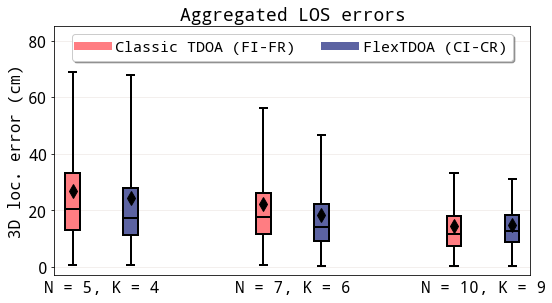

In [17]:
color_list = [mycolor["color1"], mycolor["color2"], 
              mycolor["color3"], mycolor["neutral4"]]
fig, ax = plot_series_boxplots(list_errs, figsize=(8, 4.5), 
                                xticklabels=["N = 5, K = 4", "N = 7, K = 6", "N = 10, K = 9"],
                                full_colors=color_list,
                                do_means=True,
                                width=0.4,
                                spacing=3.5,
                                whiskers=[0, 95])
ax.set_ylabel("3D loc. error (cm)")

# Add labels
labels = [dict_exp[m]["abbrev"] for m in methods]
lw = 8
for l, c in zip(labels, color_list):
    ax.plot([], c=c, linewidth=lw, label=l)
# Legend inside the plot
ax.legend(#bbox_to_anchor=(0.36, 0.47, 1, 0.5), 
          loc='upper center', 
          fancybox=True, 
          shadow=True, 
          ncol=2,
          handletextpad=0.5, # make the padding between rows smaller
          prop={'size': fontsize}, # make font smaller so all elements fit
          markerscale=1, # make markers in the legend larger
          )
ax.grid(axis="y", linestyle="-", linewidth=1, color=mycolor["neutral3"], alpha=0.3)
ax.tick_params(axis='x', which='both',length=0)
ax.set_ylim((-3, 85))
ax.set_title("Aggregated LOS errors", fontsize=18)
fig.tight_layout()
plt.show()

# VI-B: NLOS propagation

In [18]:
root_dir = os.path.join(data_dir, "nlos")

dict_exp = {
    "twr": {
        "pretty_name": "TWR",
        "abbrev": "TWR",
        "color": mycolor["color1"],
        "latex_name": "Twr",
        "recordings_filepaths": {
            "5_anchors": [
                os.path.join(root_dir, "P1", "loc_twr_5_5"),
                os.path.join(root_dir, "P4", "loc_twr_5_5"),
            ],
            "7_anchors": [
                os.path.join(root_dir, "P1", "loc_twr_7_7"),
                os.path.join(root_dir, "P4", "loc_twr_7_7"),
            ],
            "10_anchors": [
                os.path.join(root_dir, "P1", "loc_twr_10_10"),
                os.path.join(root_dir, "P4", "loc_twr_10_10"),
            ],
        },
    },
    "fi_fr": {
        "pretty_name": "Fixed initiator, fixed response order",
        "abbrev": "Classic TDOA (FI-FR)",
        "color": mycolor["color1"],
        "recordings_filepaths": {
            "5_anchors": [
                os.path.join(root_dir, "P1", "loc_tdoa_A1_FI_FR_5_4"),
                os.path.join(root_dir, "P4", "loc_tdoa_A1_FI_FR_5_4"),
            ],
            "7_anchors": [
                os.path.join(root_dir, "P1", "loc_tdoa_A1_FI_FR_7_6"),
                os.path.join(root_dir, "P4", "loc_tdoa_A1_FI_FR_7_6"),
            ],
            "10_anchors": [
                os.path.join(root_dir, "P1", "loc_tdoa_A1_FI_FR_10_9"),
                os.path.join(root_dir, "P4", "loc_tdoa_A1_FI_FR_10_9"),
            ],
        },
    },
    "ci_cr": {
        "pretty_name": "Changing initiator, changing response order",
        "abbrev": "FlexTDOA (CI-CR)",
        "color": mycolor["color4"],
        "recordings_filepaths": {
            "5_anchors": [
                os.path.join(root_dir, "P1", "loc_tdoa_CI_CR_5_4"),
                os.path.join(root_dir, "P4", "loc_tdoa_CI_CR_5_4"),
            ],
            "7_anchors": [
                os.path.join(root_dir, "P1", "loc_tdoa_CI_CR_7_6"),
                os.path.join(root_dir, "P4", "loc_tdoa_CI_CR_7_6"),
            ],
            "10_anchors": [
                os.path.join(root_dir, "P1", "loc_tdoa_CI_CR_10_9"),
                os.path.join(root_dir, "P4", "loc_tdoa_CI_CR_10_9"),
            ],
        },
    },
}

In [19]:
methods = ['twr', 'fi_fr', 'ci_cr']

latex_str = ""
list_errs = []
for m in methods:
    list_errs_methods = []
    for N in [5, 7, 10]:
        list_filepaths = dict_exp[m]["recordings_filepaths"]["{}_anchors".format(N)]
        errs_per_N = []
        for idx_filepath, filepath in enumerate(list_filepaths):
            if m == "twr":
                errs = get_localization_err(filepath, which_loc="twr_mlt", which_err="3d")
            else:
                errs = get_localization_err(filepath, which_loc="tdoa_mlt", which_err="3d")
                
            p50_3d = np.percentile(errs, 50)
            p95_3d = np.percentile(errs, 95)

            errs_per_N.extend(errs)
            
        # Print stats of aggregated errors
        p50_3d = np.percentile(errs_per_N, 50)
        p95_3d = np.percentile(errs_per_N, 95)

        print("{}, N = {}, nr meas: {}, P50 3D = {:.2f} cm, P95 3D = {:.2f} cm".format(
                m, N, len(errs_per_N), p50_3d, p95_3d))

        list_errs_methods.append(errs_per_N)
    list_errs.append(list_errs_methods)

twr, N = 5, nr meas: 15237, P50 3D = 22.30 cm, P95 3D = 62.12 cm
twr, N = 7, nr meas: 15071, P50 3D = 17.93 cm, P95 3D = 55.67 cm
twr, N = 10, nr meas: 14527, P50 3D = 14.56 cm, P95 3D = 42.04 cm
fi_fr, N = 5, nr meas: 14567, P50 3D = 29.42 cm, P95 3D = 141.47 cm
fi_fr, N = 7, nr meas: 14611, P50 3D = 23.35 cm, P95 3D = 81.34 cm
fi_fr, N = 10, nr meas: 14683, P50 3D = 22.53 cm, P95 3D = 82.07 cm
ci_cr, N = 5, nr meas: 14337, P50 3D = 22.39 cm, P95 3D = 133.08 cm
ci_cr, N = 7, nr meas: 14649, P50 3D = 15.80 cm, P95 3D = 66.55 cm
ci_cr, N = 10, nr meas: 14870, P50 3D = 14.66 cm, P95 3D = 51.25 cm


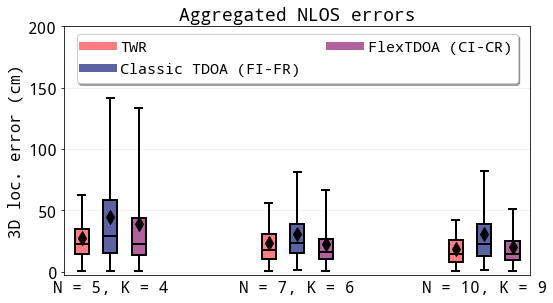

In [20]:
color_list = [mycolor["color1"], mycolor["color2"], 
              mycolor["color3"], mycolor["neutral4"]]
fig, ax = plot_series_boxplots(list_errs, figsize=(8, 4.5), 
                                xticklabels=["N = 5, K = 4", "N = 7, K = 6", "N = 10, K = 9"],
                                full_colors=color_list,
                                do_means=True,
                                width=0.4,
                                spacing=3.5,
                                whiskers=[0, 95])
ax.set_ylabel("3D loc. error (cm)")

# Add labels
labels = [dict_exp[m]["abbrev"] for m in methods]
lw = 8
for l, c in zip(labels, color_list):
    ax.plot([], c=c, linewidth=lw, label=l)
# Legend inside the plot
ax.legend(#bbox_to_anchor=(0.36, 0.47, 1, 0.5), 
          loc='upper center', 
          fancybox=True, 
          shadow=True, 
          ncol=2,
          handletextpad=0.5, # make the padding between rows smaller
          prop={'size': fontsize}, # make font smaller so all elements fit
          markerscale=1, # make markers in the legend larger
          )
ax.grid(axis="y", linestyle="-", linewidth=1, color=mycolor["neutral3"], alpha=0.3)
ax.tick_params(axis='x', which='both',length=0)
ax.set_ylim((-3, 200))
ax.set_title("Aggregated NLOS errors", fontsize=18)
fig.tight_layout()
plt.show()